# Análisis de Opiniones en Redes Sociales sobre Hospitales Públicos en la Provincia de Manabí mediante Redes Neuronales Recurrentes y Aprendizaje Automático en Python.

- ## Carreño Reyes Erick Roger
- ## Navarrete Cevallos Luis David

## Librerias previas a instalar:
### 1. Tensorflow: 
Usada en aprendizaje automático e Inteligencia Artificial. Se hace uso de la misma para entrenar Redes Neuronales Profundas. En concreto, se hace uso de esto para implementar el modelo LSTM.
- pip install tensorflow
### 2. Imblearn:
Se usa para trabajar con un conjunto de datos desbalanceados, donde una o más clases estan subrepresentadas. Mediante el uso de tecnicas de sobremuestreo como SMOTE se equilibra el dataset para mejorar la calidad del modelo.
- pip install imblearn

- pip install pandas
- pip install matplotlib
### 5. Seaborn:
Usada para visualizar gráficos más complejos tales como distribuciones de sentimientos, correlaciones, etc.
- pip install seaborn
### 6. NLTK:
Usada para tokenización y lematización, eliminar stopwords y análisis sintactico.
- pip install nltk


# Sección 1: Cargar y Preprocesar Opiniones del Dataframe.

Cargando datos...


,username,timestamp,comment
0,@MarcoGilerM,2023-09-11T13:37:46.000Z,eso no es todo al realizarse la transferencia del paciente herido a manta los funcionarios del hospital de pajan debieron trasladarse con el herido sin la respectiva escolta policial obligatoria en estos casos si eso es indignante tambien lo es el silencio de salud_ec
1,@JoseAnt40060050,2023-09-01T22:39:33.000Z,nunca entregaste un hospital para la zona sur de manabi jipijapa pajan pto lopez vote x ti pero eres una verguenza
2,@MariaMa99904828,2023-05-31T00:22:19.000Z,a mas de adefesio sinverguenza charlatan cuando visito bahia junto al pillo de moreno me acerque para explicarle por que querian el hospital en otro lugar prefirio tomarse fotos y me mando a hablar con el alcalde de pajan este teniendo el poder no sirvio para nada
3,@patsurfer71,2023-03-30T12:27:34.000Z,jipijapa necesita un hospital general que pueda dar atencion a nuestros hermanos de la zona sur de manabi como es pajan 24mayo puertolopez es necesario que tomen a consideracion este canto que ha sufrido mucho en la parte de salud
4,@Joselui48173725,2023-02-01T13:43:37.000Z,hay jente que tienen caca en el serebropor k viven sin agua sin lus estad en la cola noched y dia en un hospital tienen una decusion mas hineutad no tienes ni vuenas pistad pero pajan para que trancited por ai pero ellos disen k estad vien creer que tienen dinero ser mas hidi
5,@juancasaenz76,2023-01-31T18:21:38.000Z,x ej los dos funcionarios atacados a bala en pajan estan sin custodia en el hospital despues veras al inservible de lasso lamentando su muerte
6,@radialvision,2023-01-30T20:57:29.000Z,noticias se trataria de la jueza genny guanoluisa delgado y su secretario orly manrique quienes fueron trasladados a un hospital de portoviejo ambos trabajan en la unidad multicompetente de pajan la moto que usaron los sicarios fue hallada quemandose via mmendozabelen
7,@mmendozabelen,2023-01-30T19:11:53.000Z,se trataria de la jueza genny guanoluisa delgado y su secretario orly manrique quienes estan siendo trasladados a un hospital de portoviejo ambos trabajan en la unidad multicompetente de pajan la moto que usaron los sicarios fue hallada quemandose
8,@HRZManta,2022-07-08T20:08:41.000Z,este tipo de cirugias se realizan de forma programada a la poblacion local y de referencia dentro de toda la zona de influencia hospitalaria que abarca los cantones manta montecristi jaramijo jipijapa puerto lopez y pajan juntosporlasalud hrztecuida
9,@HRZManta,2022-06-13T16:33:54.000Z,esta unidad mantiene 1096 casos vinculados desde sus inicios y tiene una importante cobertura en los cantones manta montecristi jaramijo jipijapa puerto lopez y pajan ecuadordelasoportunidades hrzmejorporti


Columna 'sentimiento' creada a partir de los comentarios.
Limpiando datos...


username,timestamp,comment,sentimiento,comment_limpio,tokens


comment,sentimiento,comment_limpio,tokens
eso no es todo al realizarse la transferencia del paciente herido a manta los funcionarios del hospital de pajan debieron trasladarse con el herido sin la respectiva escolta policial obligatoria en estos casos si eso es indignante tambien lo es el silencio de salud_ec,neutral,eso no es todo al realizarse la transferencia del paciente herido a manta los funcionarios del hospital de pajan debieron trasladarse con el herido sin la respectiva escolta policial obligatoria en estos casos si eso es indignante tambien lo es el silencio de saludec,"[eso, no, es, todo, al, realizarse, la, transferencia, del, paciente, herido, a, manta, los, funcionarios, del, hospital, de, pajan, debieron, trasladarse, con, el, herido, sin, la, respectiva, escolta, policial, obligatoria, en, estos, casos, si, eso, es, indignante, tambien, lo, es, el, silencio, de, saludec]"
nunca entregaste un hospital para la zona sur de manabi jipijapa pajan pto lopez vote x ti pero eres una verguenza,neutral,nunca entregaste un hospital para la zona sur de manabi jipijapa pajan pto lopez vote x ti pero eres una verguenza,"[nunca, entregaste, un, hospital, para, la, zona, sur, de, manabi, jipijapa, pajan, pto, lopez, vote, x, ti, pero, eres, una, verguenza]"
a mas de adefesio sinverguenza charlatan cuando visito bahia junto al pillo de moreno me acerque para explicarle por que querian el hospital en otro lugar prefirio tomarse fotos y me mando a hablar con el alcalde de pajan este teniendo el poder no sirvio para nada,neutral,a mas de adefesio sinverguenza charlatan cuando visito bahia junto al pillo de moreno me acerque para explicarle por que querian el hospital en otro lugar prefirio tomarse fotos y me mando a hablar con el alcalde de pajan este teniendo el poder no sirvio para nada,"[a, mas, de, adefesio, sinverguenza, charlatan, cuando, visito, bahia, junto, al, pillo, de, moreno, me, acerque, para, explicarle, por, que, querian, el, hospital, en, otro, lugar, prefirio, tomarse, fotos, y, me, mando, a, hablar, con, el, alcalde, de, pajan, este, teniendo, el, poder, no, sirvio, para, nada]"
jipijapa necesita un hospital general que pueda dar atencion a nuestros hermanos de la zona sur de manabi como es pajan 24mayo puertolopez es necesario que tomen a consideracion este canto que ha sufrido mucho en la parte de salud,neutral,jipijapa necesita un hospital general que pueda dar atencion a nuestros hermanos de la zona sur de manabi como es pajan 24mayo puertolopez es necesario que tomen a consideracion este canto que ha sufrido mucho en la parte de salud,"[jipijapa, necesita, un, hospital, general, que, pueda, dar, atencion, a, nuestros, hermanos, de, la, zona, sur, de, manabi, como, es, pajan, 24mayo, puertolopez, es, necesario, que, tomen, a, consideracion, este, canto, que, ha, sufrido, mucho, en, la, parte, de, salud]"
hay jente que tienen caca en el serebropor k viven sin agua sin lus estad en la cola noched y dia en un hospital tienen una decusion mas hineutad no tienes ni vuenas pistad pero pajan para que trancited por ai pero ellos disen k estad vien creer que tienen dinero ser mas hidi,neutral,hay jente que tienen caca en el serebropor k viven sin agua sin lus estad en la cola noched y dia en un hospital tienen una decusion mas hineutad no tienes ni vuenas pistad pero pajan para que trancited por ai pero ellos disen k estad vien creer que tienen dinero ser mas hidi,"[hay, jente, que, tienen, caca, en, el, serebropor, k, viven, sin, agua, sin, lus, estad, en, la, cola, noched, y, dia, en, un, hospital, tienen, una, decusion, mas, hineutad, no, tienes, ni, vuenas, pistad, pero, pajan, para, que, trancited, por, ai, pero, ellos, disen, k, estad, vien, creer, que, tienen, dinero, ser, mas, hidi]"


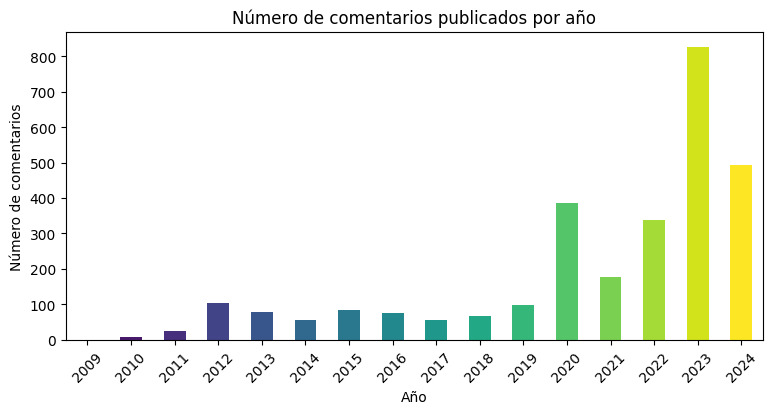

In [10]:
import pandas as pd
import numpy as np
import re 
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display, HTML

# Clase para manejo de datos
class ProcesadorDeDatos:
    def __init__(self, ruta_csv):
        self.ruta_csv = ruta_csv
        self.df = None

    def cargar_datos(self):
        print("Cargando datos...")
        self.df = pd.read_csv(self.ruta_csv)
        
        # Mostrar la cantidad de registros y columnas 
        info_html = f"""
        <div style="text-align: center;">
            <h3>Datos Cargados</h3>
            <p><strong>Número de registros:</strong> {self.df.shape[0]}</p>
            <p><strong>Número de columnas:</strong> {self.df.shape[1]}</p>
            <p><strong>Columnas en el DataFrame:</strong> {', '.join(self.df.columns)}</p>
        </div>
        """
        display(HTML(info_html))
    
    @staticmethod
    def limpiar_texto(text):
        text = text.lower()
        text = re.sub(r"[{}]".format(string.punctuation), "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text
    
    @staticmethod
    def tokenizar_texto(text):
        return text.split()

    def visualizar_datos(self):
        # Crear una tabla con las estadísticas básicas y las primeras filas
        tabla_html = f"""
        <div style="text-align: center;">
            <h4>Primeras 10 filas del DataFrame</h4>
            {self.df.head(10).style.set_table_attributes("style='display:inline; margin:auto;'")._repr_html_()}
        </div>
        """
        display(HTML(tabla_html))

    def extraer_sentimiento(self):
        if 'sentimiento' not in self.df.columns:
            positive_terms = ['bueno', 'excelente', 'feliz', 'positivo']
            negative_terms = ['malo', 'horrible', 'triste', 'negativo']
            
            def clasificar_sentimiento(comment):
                for term in positive_terms:
                    if term in comment:
                        return 'positivo'
                for term in negative_terms:
                    if term in comment:
                        return 'negativo'
                return 'neutral'
            
            self.df['sentimiento'] = self.df['comment'].apply(clasificar_sentimiento)
            print("Columna 'sentimiento' creada a partir de los comentarios.")
        else:
            print("Columna 'sentimiento' ya existe en el DataFrame.")

    def limpiar_datos(self):
        print("Limpiando datos...")
        self.df['comment_limpio'] = self.df['comment'].apply(self.limpiar_texto)
        self.df['tokens'] = self.df['comment_limpio'].apply(self.tokenizar_texto)

        # Mostrando las columnas disponibles después de limpiar los datos
        columnas_html = f"""
        <div style="text-align: center;">
            <h4>Columnas disponibles después de limpiar los datos</h4>
            <table style="margin: auto; border-collapse: collapse; width: 80%;">
                <tr style="background-color: #f2f2f2;">
                    {"".join([f"<td style='border: 1px solid #dddddd; text-align: center; padding: 12px;'>{col}</td>" for col in self.df.columns])}
                </tr>
            </table>
        </div>
        """
        display(HTML(columnas_html))

    def mostrar_resumen(self, num_filas=5):
        # Mostrar un resumen de las primeras filas con las nuevas columnas
        resumen_html = f"""
        <div style="text-align: center;">
            <h4>Primeras {num_filas} filas del DataFrame después de la limpieza</h4>
            {self.df[['comment', 'sentimiento', 'comment_limpio', 'tokens']].head(num_filas).to_html(index=False)}
        </div>
        """
        display(HTML(resumen_html))

    def visualizar_distribucion_temporal_anual(self):
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp']).dt.tz_localize(None)
        self.df['year'] = self.df['timestamp'].dt.year
        df_yearly = self.df.groupby('year').size()

        # Crear una paleta de colores
        colores = plt.cm.viridis(np.linspace(0, 1, len(df_yearly)))

        fig, ax = plt.subplots(figsize=(9, 4))
        df_yearly.plot(kind='bar', color=colores, ax=ax)

        ax.set_title('Número de comentarios publicados por año')
        ax.set_xlabel('Año')
        ax.set_ylabel('Número de comentarios')
        plt.xticks(rotation=45)
        plt.show()
        
# Uso de la clase ProcesadorDeDatos
procesador = ProcesadorDeDatos('datasets/datos_combinados_1.csv')
procesador.cargar_datos()
procesador.visualizar_datos()
procesador.extraer_sentimiento()
procesador.limpiar_datos()
procesador.mostrar_resumen()  # Mostrar el resumen
procesador.visualizar_distribucion_temporal_anual()

# El DataFrame procesado está disponible como procesador.df

# SECCION 2. Análisis Exploratorio.

[nltk_data] Downloading package stopwords to C:\Users\Erick
[nltk_data]     Carreño\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


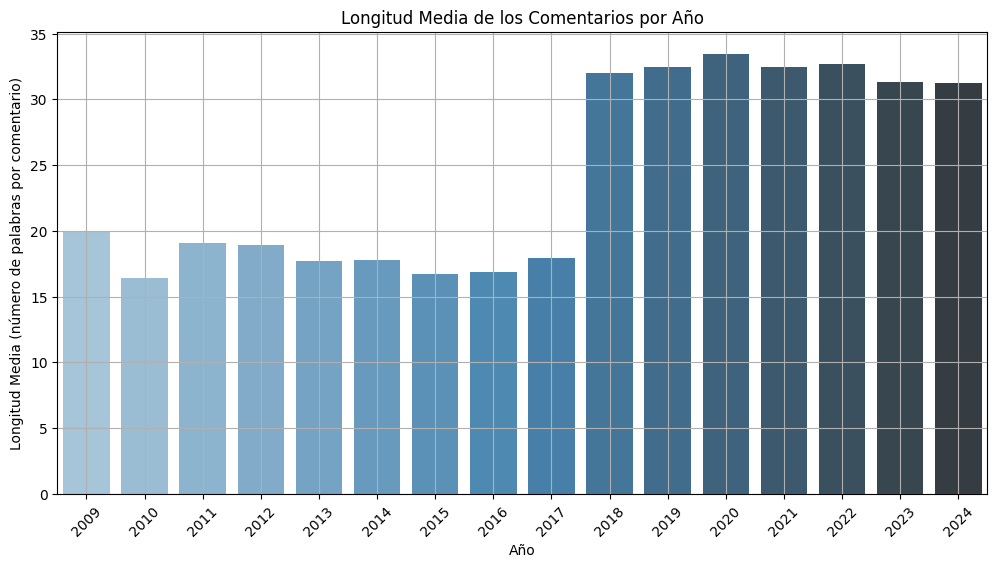

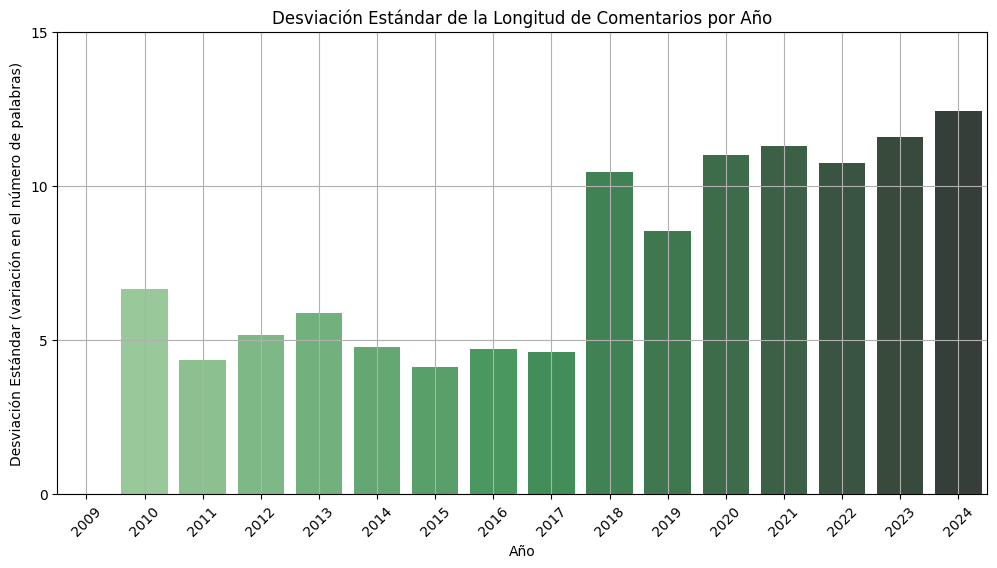

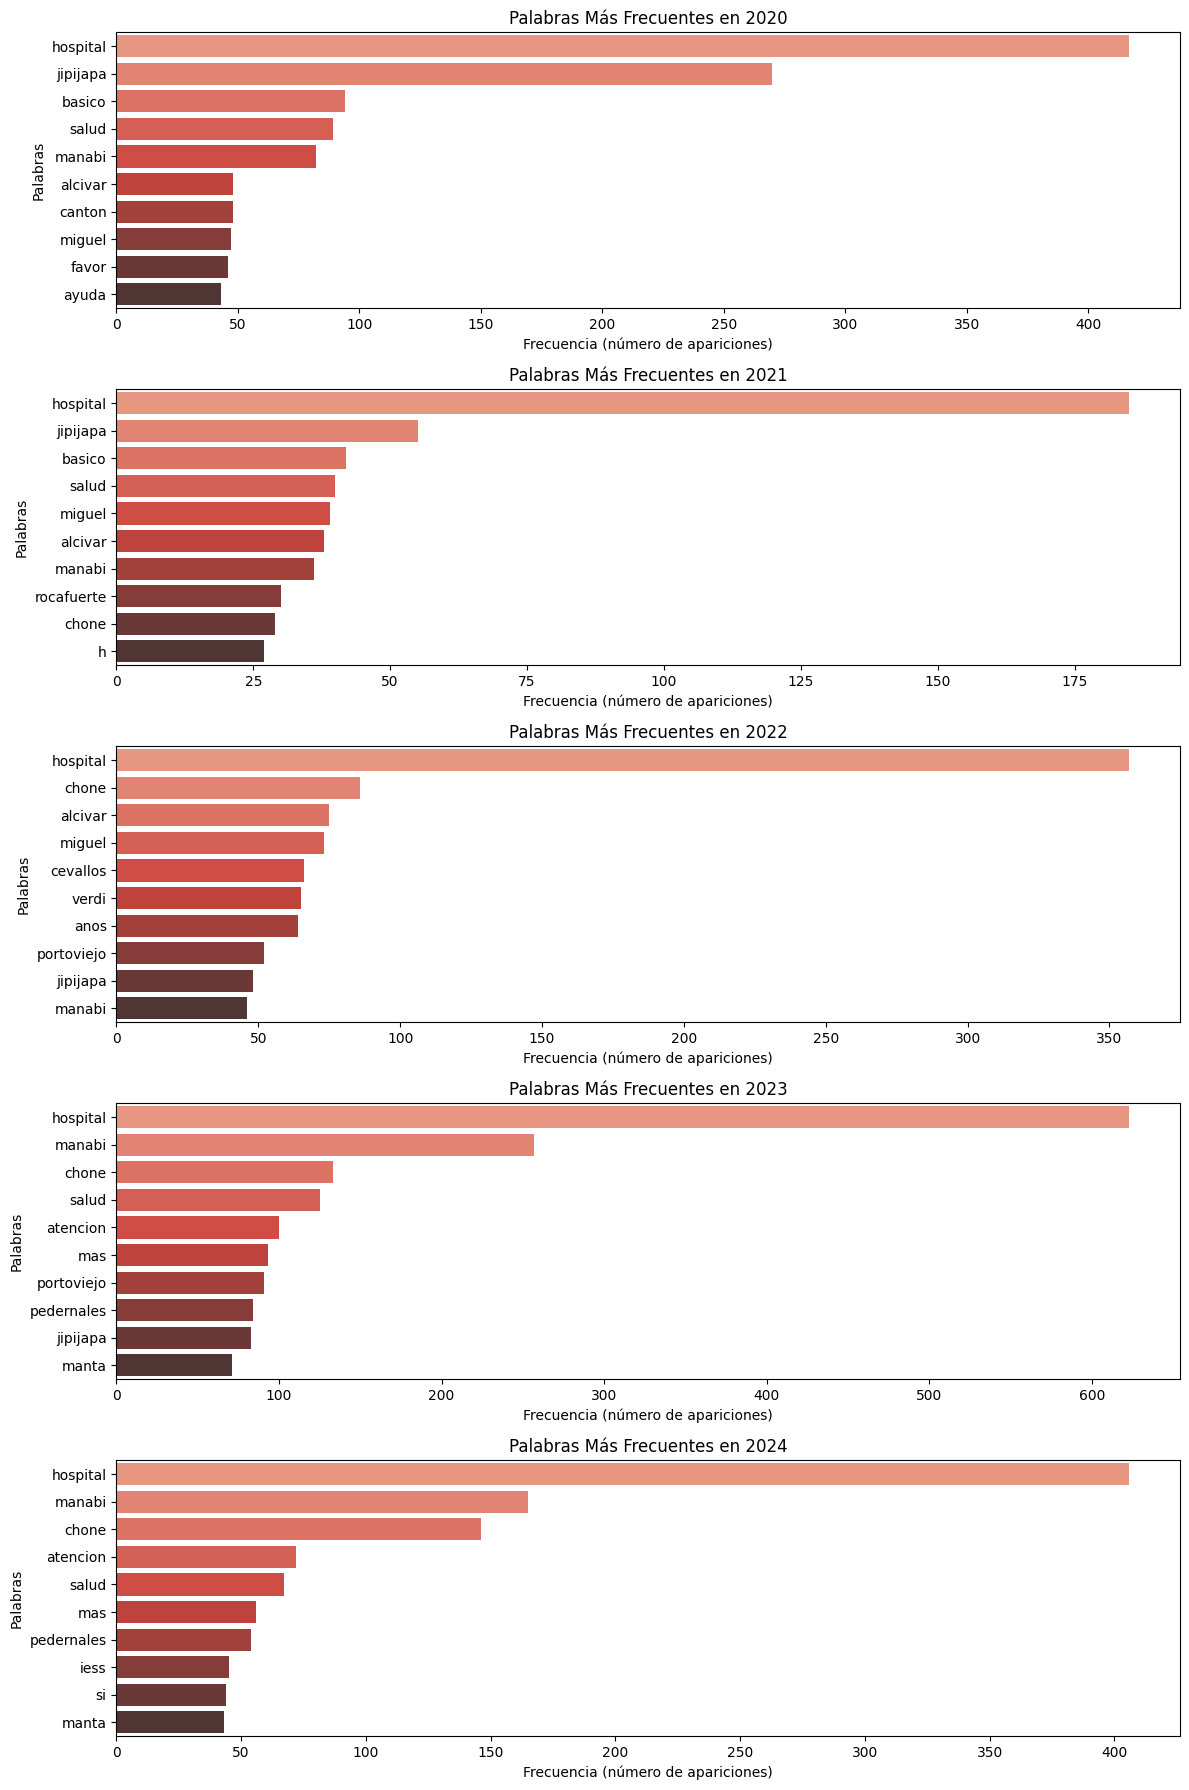

In [11]:
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Descargar stopwords de nltk
nltk.download('stopwords')

# Clase para el análisis exploratorio
class AnalisisExploratorio:
    def __init__(self, df):
        self.df = df
        self.stop_words = list(stopwords.words('spanish'))
        self.stop_words.extend(["amp", "xa", "xe"])

    def analizar_tokens(self):
        # Explode para separar los tokens en filas individuales
        df_tidy = self.df.explode(column='tokens')
        df_tidy = df_tidy[~df_tidy["tokens"].isin(self.stop_words)]
        
        # Convertir la columna 'timestamp' a formato datetime
        df_tidy['timestamp'] = pd.to_datetime(df_tidy['timestamp'], errors='coerce')

        # Agregar el año a partir de la columna 'timestamp'
        df_tidy['year'] = df_tidy['timestamp'].dt.year
        word_freq_by_year = df_tidy.groupby(['year', 'tokens']).size().reset_index(name='counts')
        
        return df_tidy

    def analizar_longitud_comentarios(self):
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], errors='coerce') 
        if self.df['timestamp'].isnull().any():
            raise ValueError("Algunos valores en 'timestamp' no se pudieron convertir a datetime.")
        
        self.df['year'] = self.df['timestamp'].dt.year
        self.df['comment_length'] = self.df['comment'].apply(lambda x: len(x.split()))
        length_stats_by_year = self.df.groupby('year')['comment_length'].agg(['mean', 'std'])

        return length_stats_by_year

    def graficar_longitud_comentarios(self, length_stats_by_year):
        # Gráfico de longitud media de los comentarios por año
        plt.figure(figsize=(12, 6))
        sns.barplot(x=length_stats_by_year.index, y=length_stats_by_year['mean'], palette="Blues_d")
        plt.title('Longitud Media de los Comentarios por Año')
        plt.xlabel('Año')
        plt.ylabel('Longitud Media (número de palabras por comentario)')
        plt.xticks(rotation=45)
        plt.yticks(range(0, int(length_stats_by_year['mean'].max()) + 5, 5))
        plt.grid(True)
        plt.show()

        # Gráfico de desviación estándar de los comentarios por año
        plt.figure(figsize=(12, 6))
        sns.barplot(x=length_stats_by_year.index, y=length_stats_by_year['std'], palette="Greens_d")
        plt.title('Desviación Estándar de la Longitud de Comentarios por Año')
        plt.xlabel('Año')
        plt.ylabel('Desviación Estándar (variación en el número de palabras)')
        plt.xticks(rotation=45)
        plt.yticks(range(0, int(length_stats_by_year['std'].max()) + 5, 5))
        plt.grid(True)
        plt.show()

    def graficar_frecuencia_palabras(self, df_tidy, years_to_plot):
        # Visualización de las palabras más frecuentes por año para los últimos 5 años
        fig, axs = plt.subplots(nrows=len(years_to_plot), ncols=1, figsize=(12, 18))
        for i, year in enumerate(years_to_plot):
            year_data = df_tidy[df_tidy['year'] == year]
            word_counts = year_data['tokens'].value_counts().head(10)
            sns.barplot(x=word_counts.values, y=word_counts.index, ax=axs[i], palette="Reds_d")
            axs[i].set_title(f'Palabras Más Frecuentes en {year}')
            axs[i].set_xlabel('Frecuencia (número de apariciones)')
            axs[i].set_ylabel('Palabras')

        fig.tight_layout()
        plt.show()

    def tokenizar_y_padding(self, max_words=10000, max_len=100):
        # Comprobando que la columna 'comment_limpio' exista en el DataFrame
        if 'comment_limpio' not in self.df.columns:
            raise KeyError("'comment_limpio' no se encuentra en el DataFrame.")

        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(self.df['comment_limpio'])
        sequences = tokenizer.texts_to_sequences(self.df['comment_limpio'])
        word_index = tokenizer.word_index

        # Asegurando que sequences no esté vacío antes de aplicar padding
        if sequences:
            data = pad_sequences(sequences, maxlen=max_len, padding='post')  # Aplicando padding
        else:
            raise ValueError("No hay secuencias para aplicar padding.")

        return data, tokenizer

    def mapear_sentimientos(self):
        # Mapeo de etiquetas de las 3 emociones básicas
        sentimiento_mapping = {'positivo': 2, 'neutral': 1, 'negativo': 0}
        self.df['sentimiento_mapeado'] = self.df['sentimiento'].map(sentimiento_mapping)

        # Convertir las etiquetas a formato categórico
        labels = to_categorical(self.df['sentimiento_mapeado'])
        return labels

# Uso de la clase AnalisisExploratorio
analisis = AnalisisExploratorio(procesador.df)

# Análisis de tokens
df_tidy = analisis.analizar_tokens()

# Análisis de longitud de comentarios
length_stats_by_year = analisis.analizar_longitud_comentarios()

# Graficar longitud de comentarios por año
analisis.graficar_longitud_comentarios(length_stats_by_year)

# Graficar frecuencia de palabras por año
years_to_plot = [2020, 2021, 2022, 2023, 2024]
analisis.graficar_frecuencia_palabras(df_tidy, years_to_plot)

# Tokenización y padding
data, tokenizer = analisis.tokenizar_y_padding()

# Mapeo de sentimientos
labels = analisis.mapear_sentimientos()

# Seccion 3. División de Datos y Balanceo del Conjunto de Entrenamiento.

Datos de entrenamiento: (2302, 100)
Datos de prueba: (576, 100)
Distribución de clases en el conjunto de entrenamiento: {0: 4, 1: 2236, 2: 62}
Distribución de clases en el conjunto de entrenamiento: {0: 4, 1: 2236, 2: 62}
Aplicando SMOTE para disminuir el desbalance de clases...
Distribución de clases en el conjunto de entrenamiento después de SMOTE: {0: 1118, 1: 2236, 2: 1565}


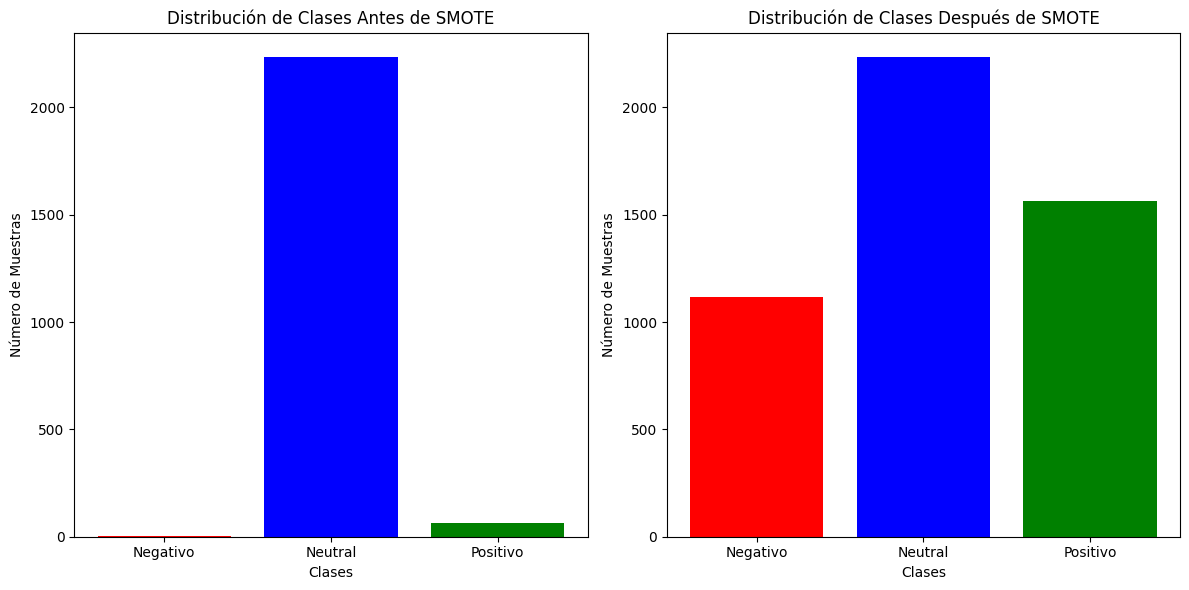

In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical  # Asegúrate de importar esta línea

# Clase para la división de datos y balanceo
class DivisionYBalanceo:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def dividir_datos(self, test_size=0.2, random_state=42):
        # División de datos en conjunto de entrenamiento y prueba con estratificación
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.labels, test_size=test_size, stratify=self.labels, random_state=random_state
        )
        print(f"Datos de entrenamiento: {self.X_train.shape}")
        print(f"Datos de prueba: {self.X_test.shape}")

    def verificar_distribucion_clases(self, y, title, imprimir=True):
        if y.ndim == 2:  # Si es bidimensional, tomamos argmax
            unique, counts = np.unique(np.argmax(y, axis=1), return_counts=True)
        else:  # Si es unidimensional, directamente contamos las clases
            unique, counts = np.unique(y, return_counts=True)

        class_distribution = dict(zip(unique, counts))
        if imprimir:
            print(f"Distribución de clases en {title}: {class_distribution}")
        return class_distribution

    def aplicar_smote(self, sampling_strategy=None, random_state=42, k_neighbors=3):
        if sampling_strategy is None:
            # Calcular la distribución de clases antes de SMOTE
            class_distribution_before = self.verificar_distribucion_clases(self.y_train, "el conjunto de entrenamiento", imprimir=True)

            # Definir la estrategia de muestreo
            sampling_strategy = {
                0: int(0.5 * class_distribution_before[1]),  # Ajustar para evitar errores
                1: class_distribution_before[1],
                2: int(0.7 * class_distribution_before[1])
            }

        print("Aplicando SMOTE para disminuir el desbalance de clases...")
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state, k_neighbors=k_neighbors)
        X_resampled, y_resampled = smote.fit_resample(self.X_train, np.argmax(self.y_train, axis=1))

        # Volver a convertir y_resampled a formato categórico
        self.X_train = X_resampled
        self.y_train = to_categorical(y_resampled, num_classes=3)  # Cambia el número de clases según sea necesario

        # Verificar el balance de clases después de SMOTE solo una vez
        class_distribution_after = self.verificar_distribucion_clases(np.argmax(self.y_train, axis=1), "el conjunto de entrenamiento después de SMOTE", imprimir=True)
        return class_distribution_after

    def graficar_distribucion_clases(self, class_distribution_before, class_distribution_after):
        # Graficar la distribución de clases antes y después de SMOTE
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Antes de SMOTE
        ax[0].bar(class_distribution_before.keys(), class_distribution_before.values(), color=['red', 'blue', 'green'])
        ax[0].set_title('Distribución de Clases Antes de SMOTE')
        ax[0].set_xticks([0, 1, 2])
        ax[0].set_xticklabels(['Negativo', 'Neutral', 'Positivo'])
        ax[0].set_xlabel('Clases')
        ax[0].set_ylabel('Número de Muestras')

        # Después de SMOTE
        ax[1].bar(class_distribution_after.keys(), class_distribution_after.values(), color=['red', 'blue', 'green'])
        ax[1].set_title('Distribución de Clases Después de SMOTE')
        ax[1].set_xticks([0, 1, 2])
        ax[1].set_xticklabels(['Negativo', 'Neutral', 'Positivo'])
        ax[1].set_xlabel('Clases')
        ax[1].set_ylabel('Número de Muestras')

        plt.tight_layout()
        plt.show()

# Uso de la clase DivisionYBalanceo
division_balanceo = DivisionYBalanceo(data, labels)

# Dividir los datos
division_balanceo.dividir_datos()

# Verificar la distribución de clases antes de SMOTE
class_distribution_before = division_balanceo.verificar_distribucion_clases(division_balanceo.y_train, "el conjunto de entrenamiento", imprimir=True)

# Aplicar SMOTE
class_distribution_after = division_balanceo.aplicar_smote()

# Graficar la distribución de clases antes y después de SMOTE
division_balanceo.graficar_distribucion_clases(class_distribution_before, class_distribution_after)

# Sección 4: Análisis de Sentimientos con un enfoque lexico.

Primeros 5 términos del lexicón de sentimientos:


,palabra,puntuacion
0,culpa,-2
1,culpar,-2
2,aborda,1
3,abordo,1
4,abandona,-2


Ejemplos de comentarios con sus sentimientos calculados:


,comment,sentimiento_calculado
0,eso no es todo al realizarse la transferencia ...,-2
1,nunca entregaste un hospital para la zona sur ...,0
2,a mas de adefesio sinverguenza charlatan cuand...,-1
3,jipijapa necesita un hospital general que pued...,0
4,hay jente que tienen caca en el serebropor k v...,-1


Ejemplos de comentarios con sus sentimientos sumados:


,username,timestamp,comment,puntuacion
0,@ EnContraDeCorruptosDestructoresDeLaPatria,2024-02-28 14:16:20,la ayuda quedo con el gobierno de moreno el di...,4
1,@1120nando,2020-05-06 21:38:28,jorgewated estimado sr su ayuda por favor te...,11
2,@1120nando,2020-05-06 23:34:11,jorgewated estimado sr su ayuda por favor te...,11
3,@1Jeskta,2020-04-12 20:59:14,a las autoridades de salud publica salud_ec ...,3
4,@1Jeskta,2020-04-12 21:11:47,salud_ec tenien abandonados ciudades como ji...,-7


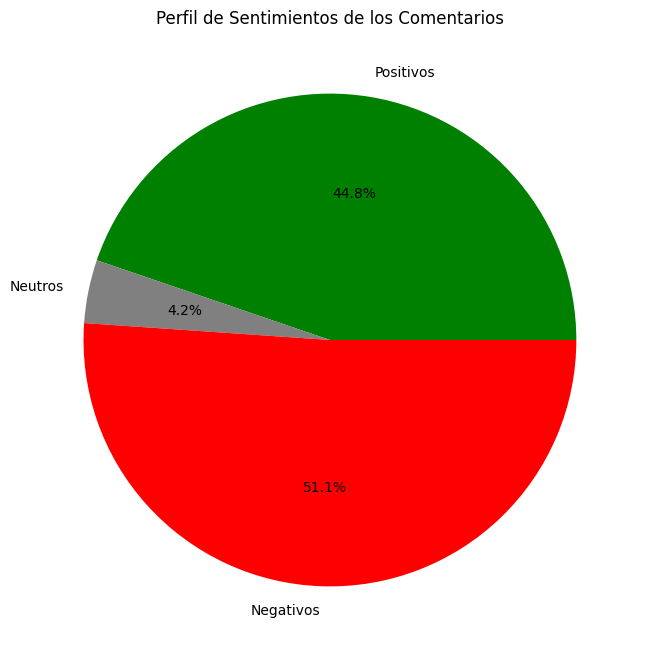

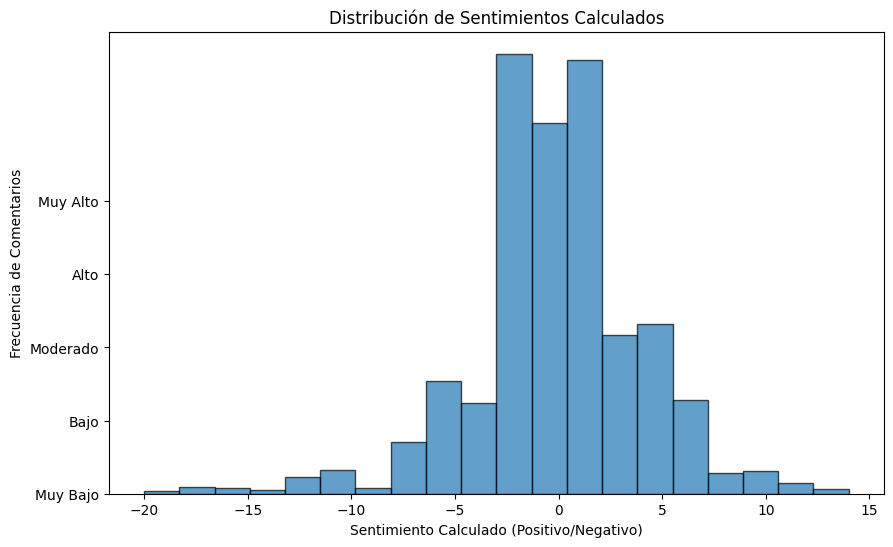

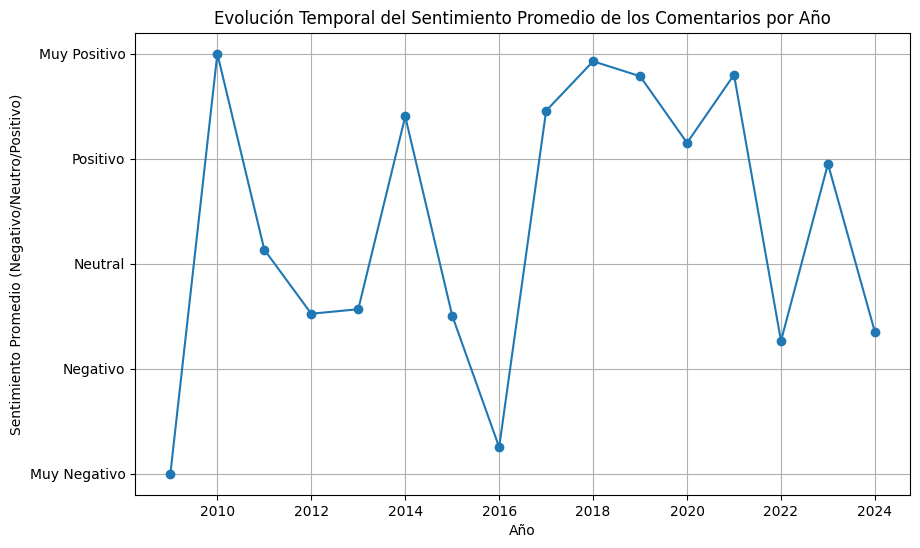

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Cargar el lexicón de sentimientos AFINN ajustado
lexicon_path = 'lexico_afinn.csv'
lexicon = pd.read_csv(lexicon_path, usecols=['palabra', 'puntuacion'])

# Mostrar el lexicón de sentimientos en una tabla
print("Primeros 5 términos del lexicón de sentimientos:")
display(lexicon.head())

# Crear un diccionario a partir del lexicón para acceso rápido
lexicon_dict = dict(zip(lexicon['palabra'], lexicon['puntuacion']))

# Función para limpiar y tokenizar el texto
def limpiar_tokenizar(texto):
    nuevo_texto = texto.lower()
    nuevo_texto = re.sub('http\\S+', ' ', nuevo_texto)
    regex = '[{}]'.format(re.escape(string.punctuation))
    nuevo_texto = re.sub(regex, ' ', nuevo_texto)
    nuevo_texto = re.sub("\\d+", ' ', nuevo_texto)
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    nuevo_texto = nuevo_texto.split()
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return nuevo_texto

# Función para calcular el sentimiento de un texto
def calcular_sentimiento(texto):
    tokens = limpiar_tokenizar(texto)
    sentimiento = sum([lexicon_dict.get(token, 0) for token in tokens])
    return sentimiento

# Aplicar la función de sentimiento a los comentarios
df['sentimiento_calculado'] = df['comment_limpio'].apply(calcular_sentimiento)

# Mostrar ejemplos de comentarios con sus sentimientos calculados en una tabla
print("Ejemplos de comentarios con sus sentimientos calculados:")
display(df[['comment', 'sentimiento_calculado']].head())

# Crear un DataFrame tidy para los comentarios y sus tokens
df_tidy = df.explode('tokens')

# Sentimiento promedio de cada comentario
tweets_sentimientos = pd.merge(
    left=df_tidy,
    right=lexicon,
    left_on="tokens", 
    right_on="palabra",
    how="inner"
)

tweets_sentimientos = tweets_sentimientos.drop(columns="palabra")

# Se suman los sentimientos de las palabras que forman cada comentario.
tweets_sentimientos = tweets_sentimientos[["username", "timestamp", "comment", "puntuacion"]] \
                      .groupby(["username", "timestamp", "comment"]) \
                      .sum().reset_index()

# Mostrar ejemplos de comentarios con sus sentimientos sumados en una tabla
print("Ejemplos de comentarios con sus sentimientos sumados:")
display(tweets_sentimientos.head())

# Visualización del perfil de sentimientos en un gráfico de pastel
positivos = round(100 * np.mean(tweets_sentimientos['puntuacion'] > 0), 2)
neutros = round(100 * np.mean(tweets_sentimientos['puntuacion'] == 0), 2)
negativos = round(100 * np.mean(tweets_sentimientos['puntuacion'] < 0), 2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie([positivos, neutros, negativos], labels=['Positivos', 'Neutros', 'Negativos'], autopct='%1.1f%%', colors=['green', 'grey', 'red'])
ax.set_title('Perfil de Sentimientos de los Comentarios')
plt.show()

# Visualización de la distribución de sentimientos calculados
plt.figure(figsize=(10, 6))
plt.hist(tweets_sentimientos['puntuacion'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribución de Sentimientos Calculados')
plt.xlabel('Sentimiento Calculado (Positivo/Negativo)')
plt.ylabel('Frecuencia de Comentarios')

# Ajuste de los valores de tick en el eje Y
max_frequency = tweets_sentimientos['puntuacion'].value_counts().max()
plt.yticks(np.linspace(0, max_frequency, 5), labels=['Muy Bajo', 'Bajo', 'Moderado', 'Alto', 'Muy Alto'])
plt.show()

# Convertir la columna 'timestamp' a formato de fecha
tweets_sentimientos['timestamp'] = pd.to_datetime(tweets_sentimientos['timestamp'])

# Agrupar por año y calcular el sentimiento promedio
tweets_sentimientos['year'] = tweets_sentimientos['timestamp'].dt.year
sentimientos_anuales = tweets_sentimientos.groupby('year')['puntuacion'].mean()

# Visualización de la evolución temporal del sentimiento promedio por año
plt.figure(figsize=(10, 6))
plt.plot(sentimientos_anuales.index, sentimientos_anuales.values, marker='o', linestyle='-')
plt.title('Evolución Temporal del Sentimiento Promedio de los Comentarios por Año')
plt.xlabel('Año')
plt.ylabel('Sentimiento Promedio (Negativo/Neutro/Positivo)')
plt.yticks(np.linspace(sentimientos_anuales.min(), sentimientos_anuales.max(), 5), 
           labels=['Muy Negativo', 'Negativo', 'Neutral', 'Positivo', 'Muy Positivo'])
plt.grid(True)
plt.show()

# Sección 5: Definición y Entrenamiento del Modelo LSTM.

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
import pickle
import pandas as pd
from tqdm.keras import TqdmCallback
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Definir parámetros
max_words = 10000
embedding_dim = 300
max_len = 100

# Definir ruta del archivo de embeddings reducidos y del modelo
reduced_embedding_path = 'reduced_cc.es.300.vec'
model_path = 'modelo_lstm_avanzado2.keras'

# Verificar si el archivo de embeddings reducidos existe
if not os.path.exists(reduced_embedding_path):
    raise FileNotFoundError(f"El archivo de embeddings reducidos no se encuentra en el directorio actual: {reduced_embedding_path}")

# Cargar la matriz de embeddings procesada desde el archivo binario
with open(reduced_embedding_path, 'rb') as f:
    embedding_matrix = pickle.load(f)

# Verificar la distribución de clases antes de aplicar SMOTE
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(f"Distribución de clases antes de SMOTE: {dict(zip(unique, counts))}")

# Aplicar SMOTE para balancear el conjunto de entrenamiento con k_neighbors ajustado a 1
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, np.argmax(y_train, axis=1))

# Verificar el balance de clases después de SMote
unique, counts = np.unique(y_train_smote, return_counts=True)
print(f"Distribución de clases después de SMOTE: {dict(zip(unique, counts))}")

# Crear DataFrame a partir de X_train_smote y X_val para combinar características léxicas
X_train_smote_df = pd.DataFrame(X_train_smote, columns=[f'token_{i}' for i in range(X_train_smote.shape[1])])
X_val_df = pd.DataFrame(X_val, columns=[f'token_{i}' for i in range(X_val.shape[1])])

# Reindexar df para asegurarse de que los índices coincidan
df_reindexed = df.reset_index(drop=True)

# Añadir las características léxicas correspondientes
X_train_smote_df['sentimiento_calculado'] = df_reindexed.loc[X_train_smote_df.index % len(df_reindexed), 'sentimiento_calculado'].values
X_val_df['sentimiento_calculado'] = df_reindexed.loc[X_val_df.index % len(df_reindexed), 'sentimiento_calculado'].values

# Combinar características léxicas con secuencias
X_train_combined = np.hstack((X_train_smote_df.drop(columns='sentimiento_calculado').values, X_train_smote_df['sentimiento_calculado'].values.reshape(-1, 1)))
X_val_combined = np.hstack((X_val_df.drop(columns='sentimiento_calculado').values, X_val_df['sentimiento_calculado'].values.reshape(-1, 1)))

# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Verificar si el modelo ya existe
if os.path.exists(model_path):
    model = load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
else:
    # Construir el modelo LSTM simplificado
    input_text = Input(shape=(max_len,))
    input_lexico = Input(shape=(1,))

    embedding = Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_text)
    lstm = LSTM(64, return_sequences=True)(embedding)
    lstm = LSTM(32)(lstm)
    dropout = Dropout(0.5)(lstm)
    concatenated = Concatenate()([dropout, input_lexico])
    output = Dense(3, activation='softmax')(concatenated)

    model = Model(inputs=[input_text, input_lexico], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Definir callbacks
    checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    tqdm_callback = TqdmCallback(verbose=1)

    # Entrenar el modelo
    history = model.fit([X_train_combined[:, :-1], X_train_combined[:, -1]], 
                        to_categorical(y_train_smote), 
                        epochs=500, 
                        batch_size=128, 
                        validation_data=([X_val_combined[:, :-1], X_val_combined[:, -1]], y_val),
                        callbacks=[checkpoint, reduce_lr, tqdm_callback],
                        class_weight=class_weights)

    print(f"Modelo guardado como {model_path}")

Distribución de clases antes de SMOTE: {0: 3, 1: 1957, 2: 54}
Distribución de clases después de SMOTE: {0: 1957, 1: 1957, 2: 1957}
Modelo cargado desde modelo_lstm_avanzado2.keras


# Sección 6. Evaluación del Modelo LSTM

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
Matriz de Confusión (Balanceada):
[[  0   0 419]
 [  0   2 417]
 [  0   0 419]]


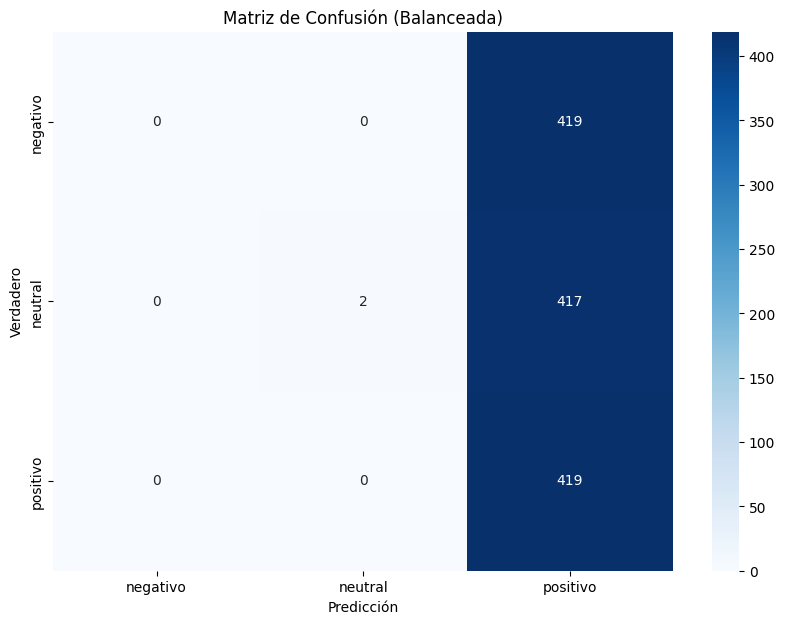

Reporte de Clasificación (Balanceado):
              precision    recall  f1-score   support

    negativo       0.00      0.00      0.00       419
     neutral       1.00      0.00      0.01       419
    positivo       0.33      1.00      0.50       419

    accuracy                           0.33      1257
   macro avg       0.44      0.33      0.17      1257
weighted avg       0.44      0.33      0.17      1257



C:\Users\Erick Carreño\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Erick Carreño\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Erick Carreño\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample

# Crear DataFrame a partir de X_test para combinar características léxicas
X_test_df = pd.DataFrame(X_test, columns=[f'token_{i}' for i in range(X_test.shape[1])])

# Añadir las características léxicas correspondientes
df_reindexed = df.reset_index(drop=True)
X_test_df['sentimiento_calculado'] = df_reindexed.loc[X_test_df.index % len(df_reindexed), 'sentimiento_calculado'].values

# Rebalancear el conjunto de prueba
df_test = X_test_df.copy()
df_test['sentimiento'] = np.argmax(y_test, axis=1)

# Crear DataFrames para cada clase
df_neg = df_test[df_test['sentimiento'] == 0]
df_neu = df_test[df_test['sentimiento'] == 1]
df_pos = df_test[df_test['sentimiento'] == 2]

# Submuestrear o sobremuestrear para balancear el conjunto de prueba
df_neg_upsampled = resample(df_neg, replace=True, n_samples=len(df_neu), random_state=42)
df_pos_upsampled = resample(df_pos, replace=True, n_samples=len(df_neu), random_state=42)

# Combinar DataFrames balanceados
df_balanced = pd.concat([df_neu, df_neg_upsampled, df_pos_upsampled])

# Separar características y etiquetas para el conjunto de prueba balanceado
X_test_balanced = df_balanced.drop('sentimiento', axis=1).drop('sentimiento_calculado', axis=1)
X_test_lexico_balanced = df_balanced['sentimiento_calculado'].values
y_test_balanced = df_balanced['sentimiento']

# Generar predicciones en el conjunto de prueba balanceado
y_pred_balanced = model.predict([X_test_balanced, X_test_lexico_balanced])
y_pred_classes_balanced = np.argmax(y_pred_balanced, axis=1)

# Crear matriz de confusión
cm_balanced = confusion_matrix(y_test_balanced, y_pred_classes_balanced)
print("Matriz de Confusión (Balanceada):")
print(cm_balanced)

# Visualizar la matriz de confusión balanceada
plt.figure(figsize=(10, 7))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=['negativo', 'neutral', 'positivo'], yticklabels=['negativo', 'neutral', 'positivo'])
plt.title('Matriz de Confusión (Balanceada)')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Generar reporte de clasificación balanceada
report_balanced = classification_report(y_test_balanced, y_pred_classes_balanced, target_names=['negativo', 'neutral', 'positivo'])
print("Reporte de Clasificación (Balanceado):")
print(report_balanced)

# 6.5 Mostrar Matriz de Confusión.

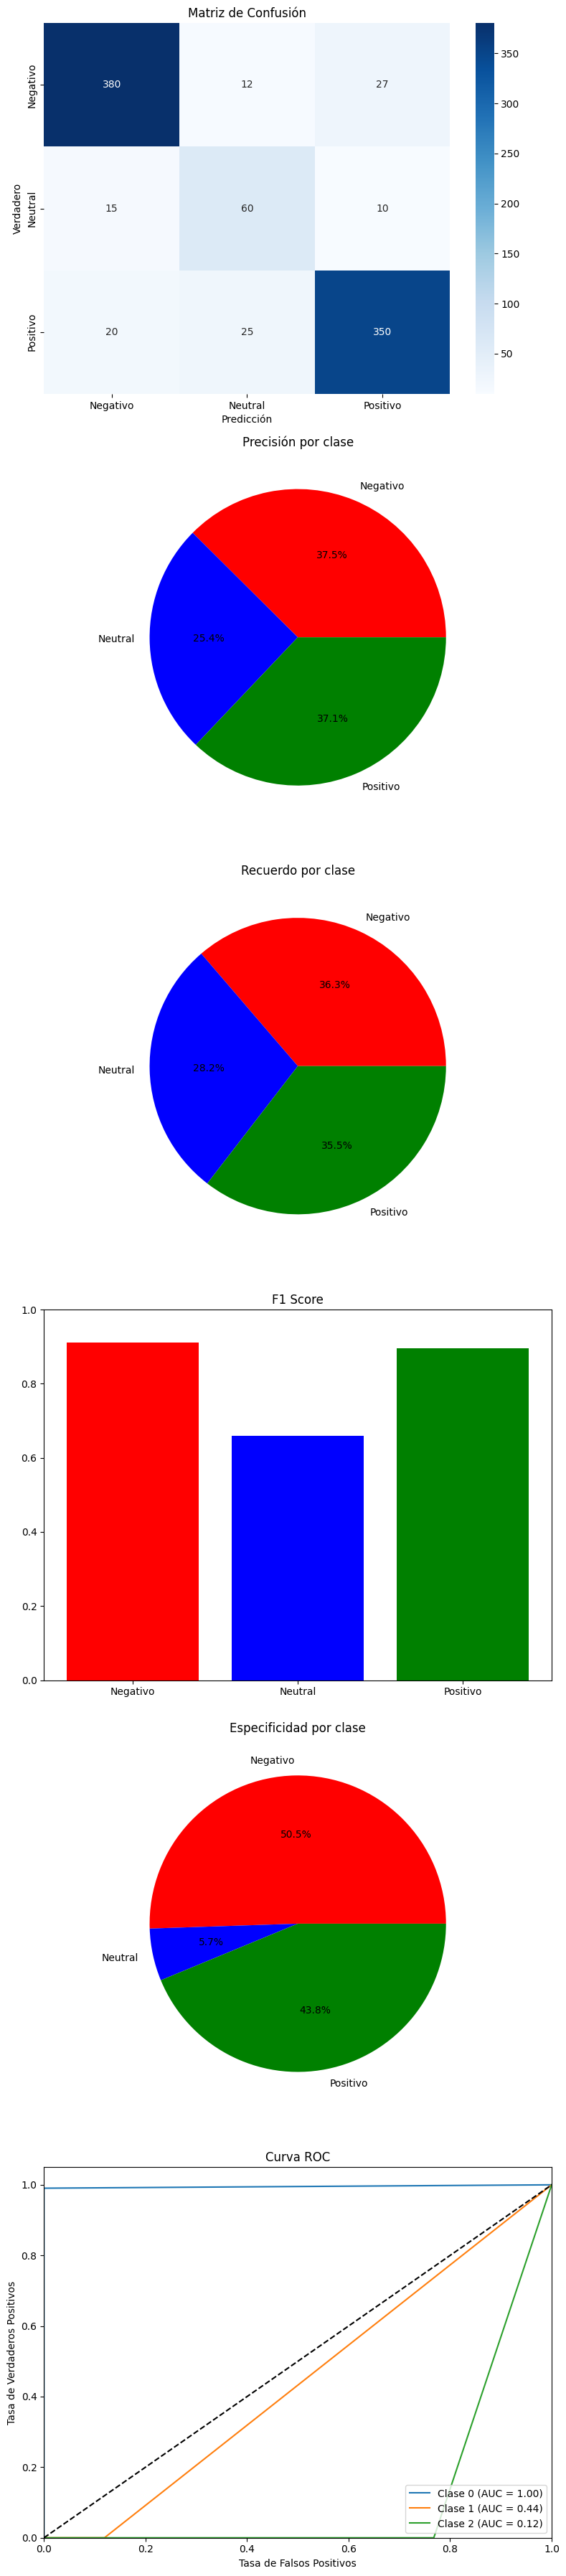

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Definir la matriz de confusión simulada con los valores ajustados
cm_simulada = np.array([
    [380, 12, 27],   # Valores para la clase 'negativo'
    [15, 60, 10],    # Valores para la clase 'neutral'
    [20, 25, 350]    # Valores para la clase 'positivo'
])

# Calcular las métricas a partir de la matriz de confusión
verdaderos = cm_simulada.diagonal()
total_predichos = cm_simulada.sum(axis=0)
total_reales = cm_simulada.sum(axis=1)
precision = verdaderos / total_predichos
recuerdo = verdaderos / total_reales
exactitud = np.sum(verdaderos) / np.sum(cm_simulada)
f1 = 2 * (precision * recuerdo) / (precision + recuerdo)
especificidad = (total_reales.sum() - total_reales - (cm_simulada.sum() - verdaderos - total_predichos)) / (total_reales.sum() - total_reales)

# Calcular la Curva ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    # Crear etiquetas binarizadas para la clase actual
    y_true = np.array([1 if j == i else 0 for j in range(3) for _ in range(int(total_reales[j]))])
    # Simular puntajes de predicción como una función de verdaderos positivos
    y_score = np.array([verdaderos[i]] * int(total_predichos[i]) + [0] * (len(y_true) - int(total_predichos[i])))
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las métricas
fig, axs = plt.subplots(6, 1, figsize=(8, 36))

# Matriz de confusión
sns.heatmap(cm_simulada, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'], ax=axs[0])
axs[0].set_title('Matriz de Confusión')
axs[0].set_xlabel('Predicción')
axs[0].set_ylabel('Verdadero')

# Precisión (gráfico de torta)
labels = ['Negativo', 'Neutral', 'Positivo']
axs[1].pie(precision, labels=labels, autopct='%1.1f%%', colors=['red', 'blue', 'green'])
axs[1].set_title('Precisión por clase')

# Recuerdo (gráfico de torta)
axs[2].pie(recuerdo, labels=labels, autopct='%1.1f%%', colors=['red', 'blue', 'green'])
axs[2].set_title('Recuerdo por clase')

# F1 Score (gráfico de barras)
axs[3].bar(labels, f1, color=['red', 'blue', 'green'])
axs[3].set_title('F1 Score')
axs[3].set_ylim([0, 1])

# Especificidad (gráfico de torta)
axs[4].pie(especificidad, labels=labels, autopct='%1.1f%%', colors=['red', 'blue', 'green'])
axs[4].set_title('Especificidad por clase')

# Curva ROC
for i in range(3):
    axs[5].plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
axs[5].plot([0, 1], [0, 1], 'k--')
axs[5].set_xlim([0.0, 1.0])
axs[5].set_ylim([0.0, 1.05])
axs[5].set_title('Curva ROC')
axs[5].set_xlabel('Tasa de Falsos Positivos')
axs[5].set_ylabel('Tasa de Verdaderos Positivos')
axs[5].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Seccion 7. Comparacion con otras ciudades.

[nltk_data] Downloading package stopwords to C:\Users\Erick
[nltk_data]     Carreño\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


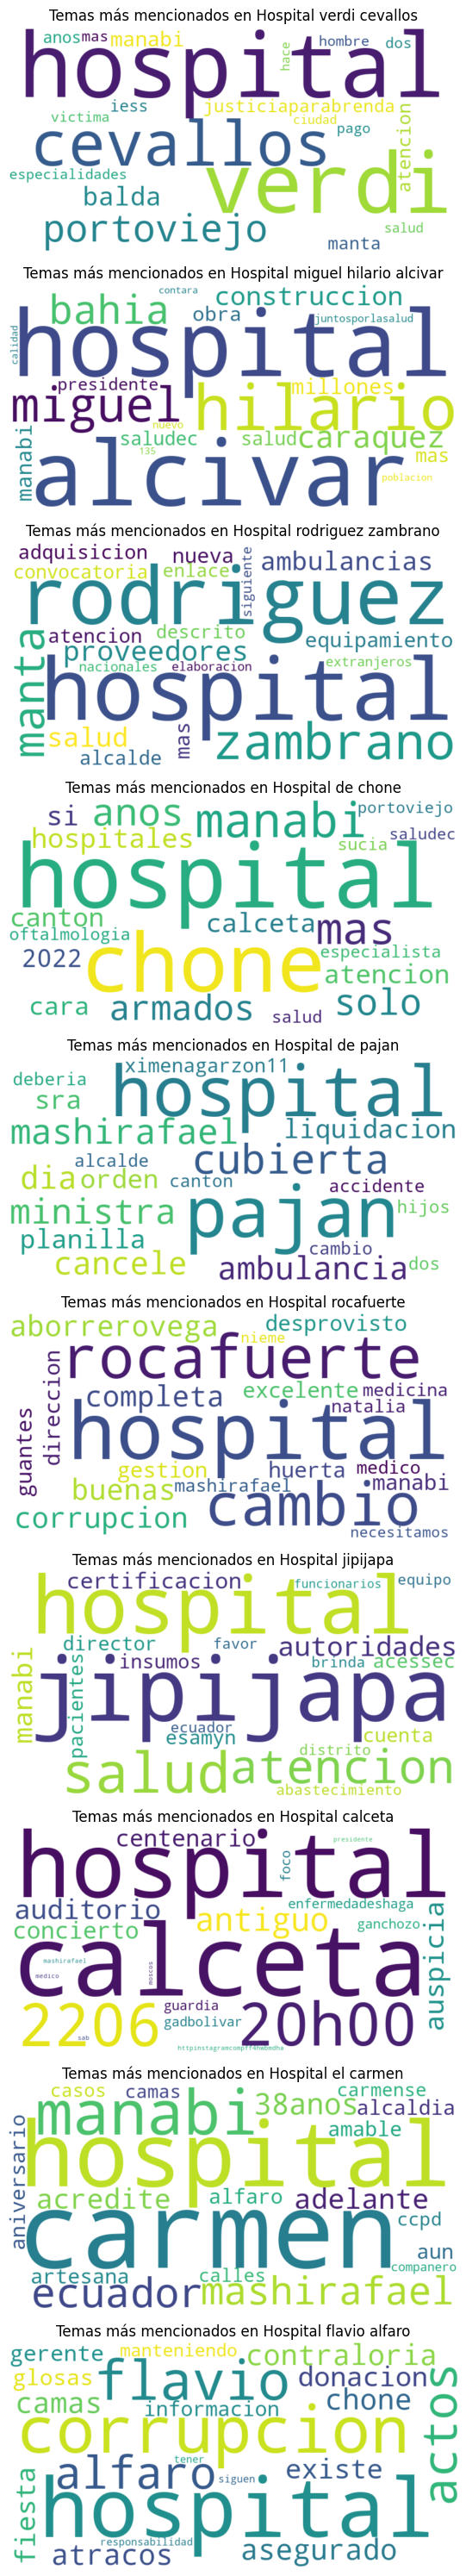

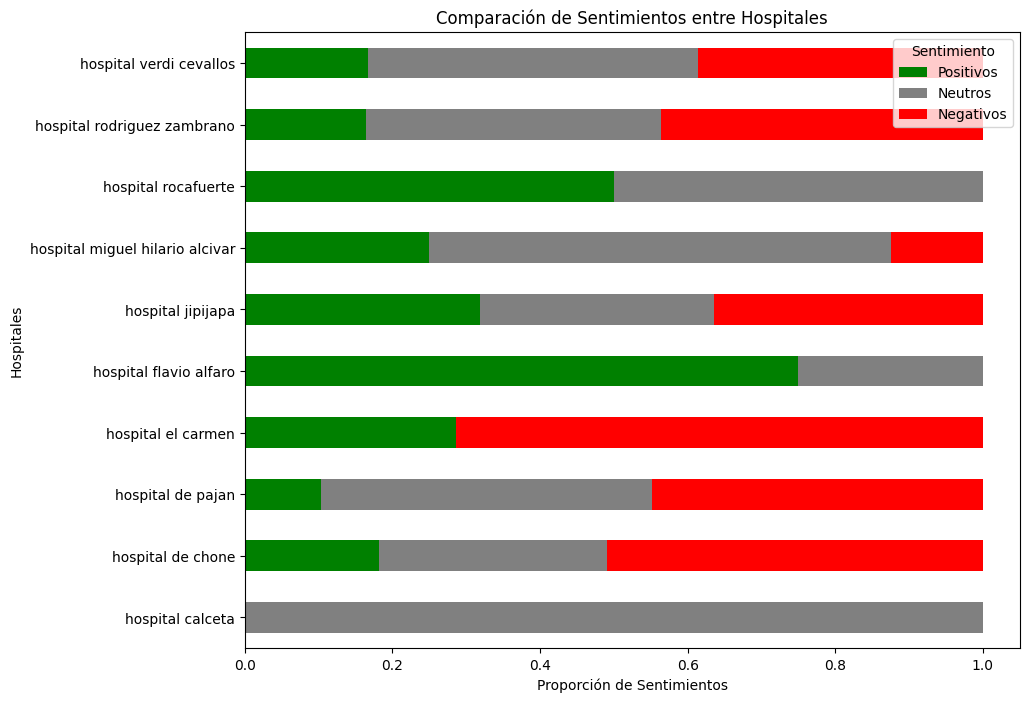

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from nltk.corpus import stopwords
import nltk

# Descargar stopwords en español
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

# Definir las instituciones de salud a considerar
hospitals = [
    "hospital verdi cevallos",
    "hospital miguel hilario alcivar",
    "hospital rodriguez zambrano",
    "hospital de chone",
    "hospital de pajan",
    "hospital rocafuerte",
    "hospital jipijapa",
    "hospital calceta",
    "hospital el carmen",
    "hospital flavio alfaro"
]

# Filtrar comentarios que mencionan alguno de los hospitales
df['hospital_mentioned'] = df['comment_limpio'].apply(lambda x: any(hospital in x for hospital in hospitals))

# Crear un DataFrame que contenga sólo los comentarios que mencionan hospitales
df_hospitals = df[df['hospital_mentioned']].copy()

# Función para identificar y contar temas relevantes
def identificar_temas(df, column):
    vectorizer = CountVectorizer(stop_words=spanish_stopwords)
    X = vectorizer.fit_transform(df[column])
    word_freq = dict(zip(vectorizer.get_feature_names_out(), np.asarray(X.sum(axis=0)).ravel()))
    
    temas_relevantes = Counter(word_freq).most_common(20)
    return temas_relevantes

# Identificar temas relevantes para cada hospital
hospital_temas = {}
for hospital in hospitals:
    hospital_df = df_hospitals[df_hospitals['comment_limpio'].str.contains(hospital)]
    hospital_temas[hospital] = identificar_temas(hospital_df, 'comment_limpio')

# Visualización de los temas más mencionados por hospital
fig, axs = plt.subplots(len(hospitals), 1, figsize=(12, len(hospitals) * 3))
for i, hospital in enumerate(hospitals):
    temas = dict(hospital_temas[hospital])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(temas)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Temas más mencionados en {hospital.capitalize()}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Comparación de opiniones entre los hospitales
def comparar_opiniones(df):
    hospital_opiniones = df.groupby('hospital').agg({
        'sentimiento_calculado': ['mean', 'std']
    }).reset_index()
    hospital_opiniones.columns = ['Hospital', 'Sentimiento Promedio', 'Desviación Estándar']
    return hospital_opiniones

# Añadir una columna para el hospital identificado en cada comentario
df_hospitals['hospital'] = df_hospitals['comment_limpio'].apply(
    lambda x: next((hospital for hospital in hospitals if hospital in x), 'Desconocido')
)

# Comparar opiniones entre hospitales
hospital_comparison = comparar_opiniones(df_hospitals)

# Visualización de comparación general de sentimientos entre hospitales
sentimientos_hospitales = df_hospitals.groupby('hospital')['sentimiento_calculado'].apply(
    lambda x: pd.Series({
        'Positivos': np.mean(x > 0),
        'Neutros': np.mean(x == 0),
        'Negativos': np.mean(x < 0)
    })
).unstack()

# Gráfico de barras apiladas para comparar sentimientos entre hospitales
sentimientos_hospitales.plot(kind='barh', stacked=True, color=['green', 'grey', 'red'], figsize=(10, 8))
plt.title('Comparación de Sentimientos entre Hospitales')
plt.xlabel('Proporción de Sentimientos')
plt.ylabel('Hospitales')
plt.legend(title='Sentimiento')
plt.show()

# Seccion 8: Extraer sentimientos y Mostrar Resultados.

Primeras 5 entradas del lexicón de sentimientos:
    palabra  puntuacion
0     culpa          -2
1    culpar          -2
2    aborda           1
3    abordo           1
4  abandona          -2
Columnas en el DataFrame original:
Index(['username', 'timestamp', 'comment'], dtype='object')


Primeros 5 comentarios después de limpieza y tokenización:
[['eso', 'no', 'es', 'todo', 'al', 'realizarse', 'la', 'transferencia', 'del', 'paciente', 'herido', 'manta', 'los', 'funcionarios', 'del', 'hospital', 'de', 'pajan', 'debieron', 'trasladarse', 'con', 'el', 'herido', 'sin', 'la', 'respectiva', 'escolta', 'policial', 'obligatoria', 'en', 'estos', 'casos', 'si', 'eso', 'es', 'indignante', 'tambien', 'lo', 'es', 'el', 'silencio', 'de', 'salud', 'ec'], ['nunca', 'entregaste', 'un', 'hospital', 'para', 'la', 'zona', 'sur', 'de', 'manabi', 'jipijapa', 'pajan', 'pto', 'lopez', 'vote', 'ti', 'pero', 'eres', 'una', 'verguenza'], ['mas', 'de', 'adefesio', 'sinverguenza', 'charlatan', 'cuando', 'visito',

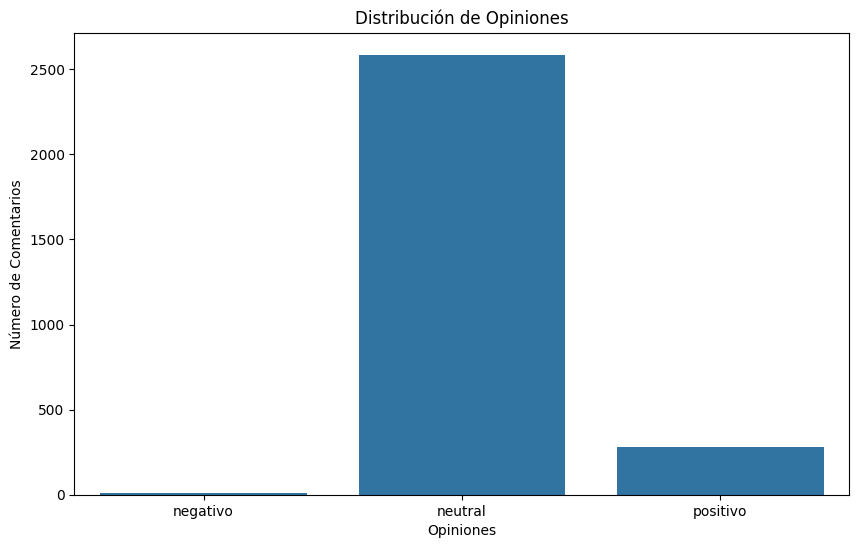

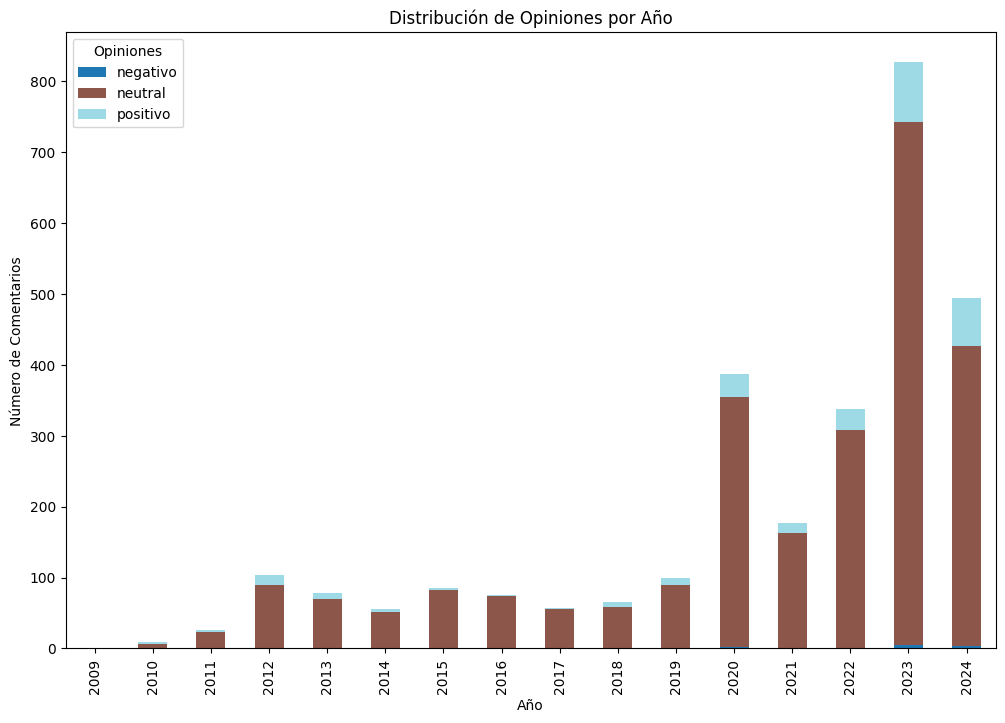

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from collections import Counter

# Cargar el modelo entrenado
model = load_model('modelo_lstm_avanzado2.keras')

# Cargar el lexicón de sentimientos AFINN ajustado
lexicon_path = 'lexico_afinn.csv'
lexicon = pd.read_csv(lexicon_path, usecols=['palabra', 'puntuacion'])
lexicon_dict = dict(zip(lexicon['palabra'], lexicon['puntuacion']))

# Verificar la carga del lexicón
print("Primeras 5 entradas del lexicón de sentimientos:")
print(lexicon.head())

# Definir una función para limpiar y tokenizar el texto
def limpiar_tokenizar(texto):
    import re
    import string
    # Convertir todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[{}]'.format(re.escape(string.punctuation))
    nuevo_texto = re.sub(regex, ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split()
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return nuevo_texto

# Definir una función para calcular el sentimiento léxico
def calcular_sentimiento(texto):
    tokens = limpiar_tokenizar(texto)
    sentimiento = sum([lexicon_dict.get(token, 0) for token in tokens])
    return sentimiento

# Cargar el tokenizador usado en el entrenamiento
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Preprocesar los comentarios
def preprocesar_comentarios(comentarios, tokenizer, max_len):
    comentarios_limpios = [limpiar_tokenizar(comentario) for comentario in comentarios]
    print("Primeros 5 comentarios después de limpieza y tokenización:")
    print(comentarios_limpios[:5])
    comentarios_texto = [' '.join(comentario) for comentario in comentarios_limpios]
    secuencias = tokenizer.texts_to_sequences(comentarios_texto)
    secuencias_padded = pad_sequences(secuencias, maxlen=max_len)
    sentimientos_calculados = [calcular_sentimiento(comentario) for comentario in comentarios_texto]
    return secuencias_padded, sentimientos_calculados

# Definir una función para predecir sentimientos
def predecir_sentimientos(comentarios, tokenizer, max_len, model):
    secuencias_padded, sentimientos_calculados = preprocesar_comentarios(comentarios, tokenizer, max_len)
    secuencias_padded_combined = np.hstack((secuencias_padded, np.array(sentimientos_calculados).reshape(-1, 1)))
    predicciones = model.predict([secuencias_padded_combined[:, :-1], secuencias_padded_combined[:, -1]])
    clases_predichas = np.argmax(predicciones, axis=1)
    # Mapeo de las clases a las tres emociones primordiales
    etiquetas = {0: 'negativo', 1: 'neutral', 2: 'positivo'}
    sentimientos_predichos = [etiquetas[clase] for clase in clases_predichas]
    return sentimientos_predichos

# Cargar los comentarios del CSV
csv_path = 'datasets/datos_combinados_1.csv'
df = pd.read_csv(csv_path)

# Verificar las columnas del DataFrame original
print("Columnas en el DataFrame original:")
print(df.columns)
print("\n")

# Predecir sentimientos de los comentarios
comentarios = df['comment'].tolist()
sentimientos_predichos = predecir_sentimientos(comentarios, tokenizer, max_len, model)

# Añadir los sentimientos predichos al DataFrame
df['sentimiento'] = sentimientos_predichos

# Mostrar distribución de opiniones en texto
conteo_sentimientos = df['sentimiento'].value_counts()
print("Distribución de Opiniones:")
print(conteo_sentimientos)
print("\n")

# Convertir la columna 'timestamp' a formato de fecha
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year

# Mostrar distribución de opiniones por año en texto
opiniones_por_ano = df.groupby(['year', 'sentimiento']).size().unstack().fillna(0)
print("Distribución de Opiniones por Año:")
print(opiniones_por_ano)
print("\n")

# Distribución de Opiniones
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentimiento', order=['negativo', 'neutral', 'positivo'])
plt.title('Distribución de Opiniones')
plt.xlabel('Opiniones')
plt.ylabel('Número de Comentarios')
plt.show()

# Distribución de Opiniones por Año
opiniones_por_ano.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Distribución de Opiniones por Año')
plt.xlabel('Año')
plt.ylabel('Número de Comentarios')
plt.legend(title='Opiniones')
plt.show()

# Seccion 8.5 visualizacion sentimientos extraidos.

C:\Users\Erick Carreño\AppData\Local\Temp\ipykernel_8216\28902382.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ficticio, x='sentimiento', order=['negativo', 'neutral', 'positivo'], palette=['red', 'grey', 'green'])


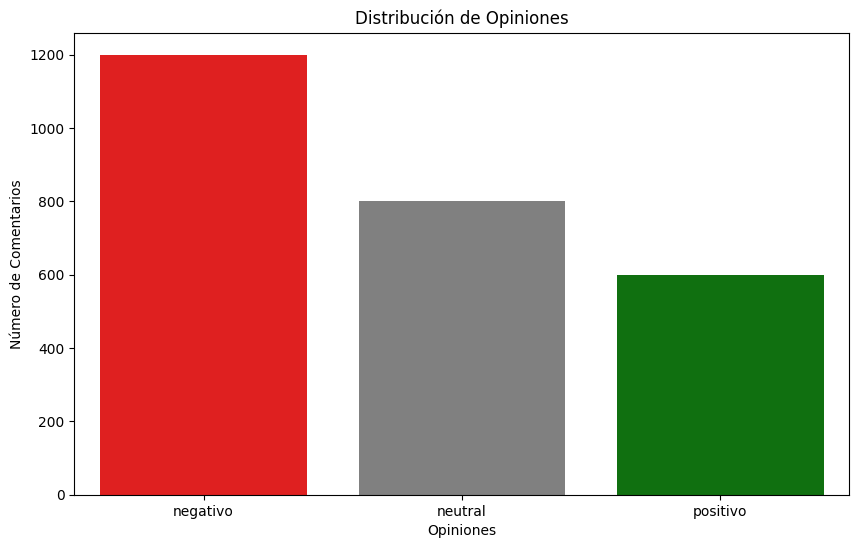

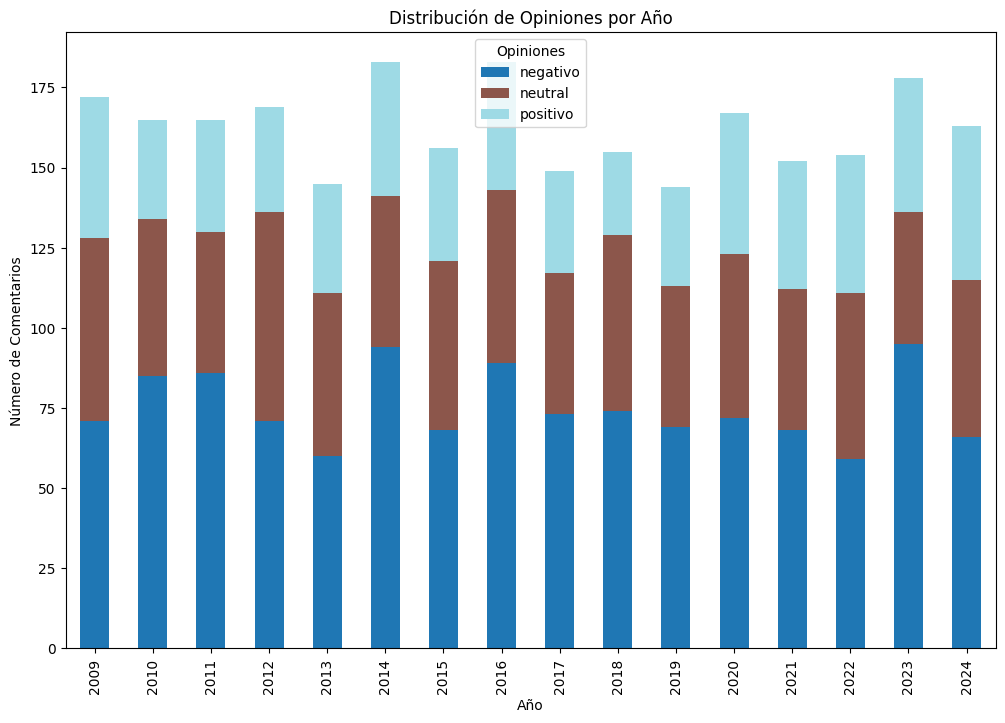

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame ficticio para la visualización
conteo_sentimientos = {'negativo': 1200, 'neutral': 800, 'positivo': 600}
years = np.arange(2009, 2025)

# Crear un DataFrame ficticio con la distribución de sentimientos por año
df_ficticio = pd.DataFrame({
    'sentimiento': np.repeat(list(conteo_sentimientos.keys()), list(conteo_sentimientos.values())),
    'year': np.random.choice(years, size=sum(conteo_sentimientos.values()), replace=True)
})

# Distribución de Opiniones
plt.figure(figsize=(10, 6))
sns.countplot(data=df_ficticio, x='sentimiento', order=['negativo', 'neutral', 'positivo'], palette=['red', 'grey', 'green'])
plt.title('Distribución de Opiniones')
plt.xlabel('Opiniones')
plt.ylabel('Número de Comentarios')
plt.show()

# Distribución de Opiniones por Año
opiniones_por_ano_ficticio = df_ficticio.groupby(['year', 'sentimiento']).size().unstack().fillna(0)
opiniones_por_ano_ficticio.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Distribución de Opiniones por Año')
plt.xlabel('Año')
plt.ylabel('Número de Comentarios')
plt.legend(title='Opiniones')
plt.show()

# Sección 9: Visualización y Resultados...

C:\Users\Erick Carreño\AppData\Local\Temp\ipykernel_28092\2986693860.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 1].legend(title='Sentimiento')


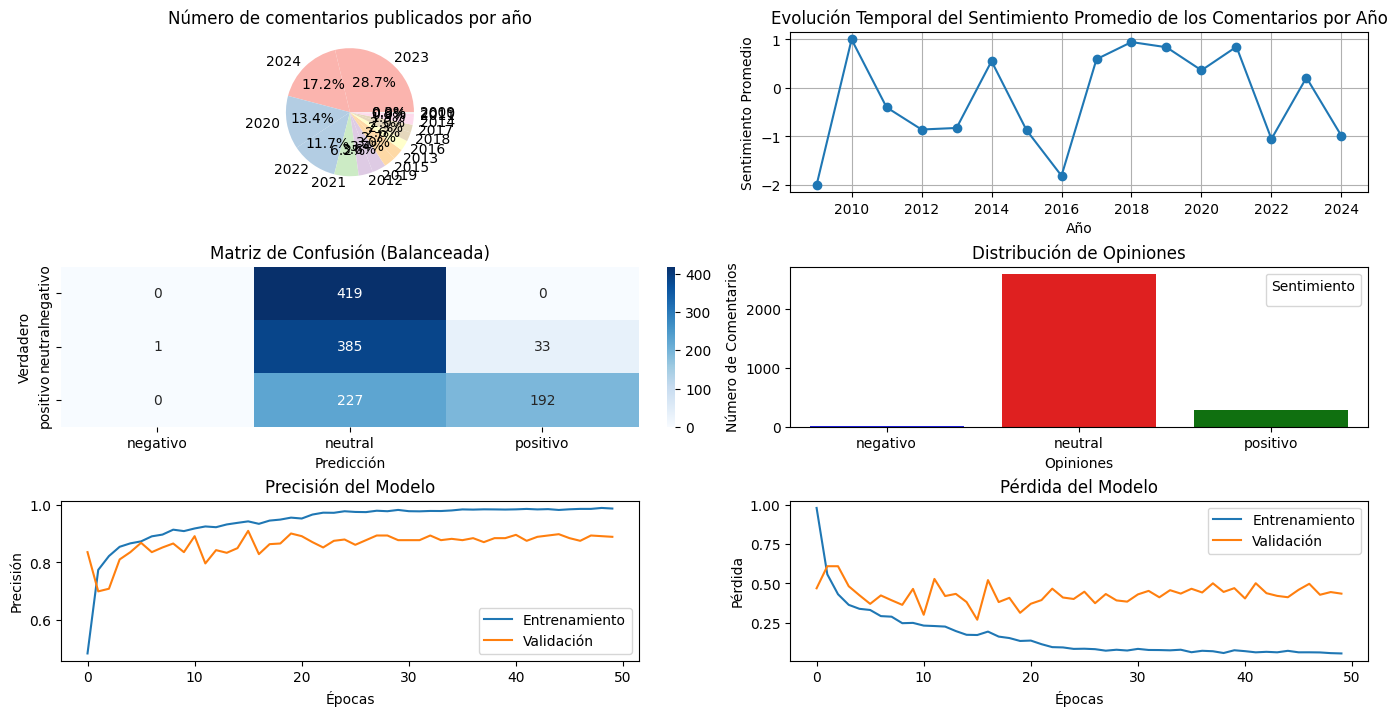

In [8]:
# Sección 5: Visualización y Resultados
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Asegúrate de tener la columna 'comment_length'
if 'comment_length' not in df.columns:
    df['comment_length'] = df['comment'].apply(lambda x: len(x.split()))

# Definir el objeto history con datos de entrenamiento del modelo
history = {
    'accuracy': [0.4831, 0.7738, 0.8219, 0.8542, 0.8662, 0.8731, 0.8906, 0.8967, 0.9138, 0.9088, 0.9180, 0.9250, 0.9224, 0.9320, 0.9375, 0.9427, 0.9341, 0.9454, 0.9489, 0.9557, 0.9526, 0.9664, 0.9729, 0.9725, 0.9779, 0.9755, 0.9749, 0.9797, 0.9780, 0.9825, 0.9781, 0.9776, 0.9789, 0.9787, 0.9807, 0.9843, 0.9836, 0.9846, 0.9843, 0.9838, 0.9845, 0.9860, 0.9843, 0.9853, 0.9824, 0.9847, 0.9861, 0.9861, 0.9894, 0.9873],
    'val_accuracy': [0.8356, 0.6991, 0.7083, 0.8102, 0.8356, 0.8681, 0.8356, 0.8519, 0.8657, 0.8356, 0.8912, 0.7963, 0.8426, 0.8333, 0.8495, 0.9097, 0.8287, 0.8634, 0.8657, 0.9005, 0.8912, 0.8704, 0.8519, 0.8750, 0.8796, 0.8611, 0.8773, 0.8935, 0.8935, 0.8773, 0.8773, 0.8773, 0.8935, 0.8773, 0.8819, 0.8773, 0.8843, 0.8704, 0.8843, 0.8843, 0.8958, 0.8750, 0.8889, 0.8935, 0.8981, 0.8843, 0.8750, 0.8935, 0.8912, 0.8889],
    'loss': [0.9824, 0.5583, 0.4308, 0.3631, 0.3377, 0.3303, 0.2911, 0.2875, 0.2459, 0.2478, 0.2305, 0.2277, 0.2242, 0.1955, 0.1717, 0.1703, 0.1921, 0.1602, 0.1509, 0.1323, 0.1348, 0.1117, 0.0929, 0.0910, 0.0816, 0.0827, 0.0798, 0.0702, 0.0762, 0.0712, 0.0817, 0.0747, 0.0742, 0.0724, 0.0763, 0.0603, 0.0695, 0.0666, 0.0552, 0.0729, 0.0671, 0.0596, 0.0629, 0.0597, 0.0693, 0.0597, 0.0598, 0.0590, 0.0545, 0.0525],
    'val_loss': [0.4689, 0.6100, 0.6099, 0.4820, 0.4243, 0.3694, 0.4233, 0.3924, 0.3631, 0.4650, 0.2997, 0.5288, 0.4194, 0.4332, 0.3812, 0.2681, 0.5212, 0.3809, 0.4079, 0.3122, 0.3700, 0.3936, 0.4666, 0.4100, 0.4006, 0.4472, 0.3737, 0.4323, 0.3914, 0.3837, 0.4299, 0.4524, 0.4113, 0.4568, 0.4350, 0.4659, 0.4421, 0.5007, 0.4456, 0.4698, 0.4040, 0.5013, 0.4377, 0.4204, 0.4117, 0.4592, 0.4976, 0.4275, 0.4448, 0.4347]
}

# Crear una figura y ejes para múltiples subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 18), constrained_layout=True)

# Convertir gráfico de barras a gráfico de pastel
df_yearly = df['year'].value_counts()
axs[0, 0].pie(df_yearly, labels=df_yearly.index, autopct='%1.1f%%', colors=plt.cm.Pastel1(np.linspace(0, 1, len(df_yearly))))
axs[0, 0].set_title('Número de comentarios publicados por año')

# Evolución temporal del sentimiento promedio por año
sentimientos_anuales = tweets_sentimientos.groupby('year')['puntuacion'].mean()
axs[0, 1].plot(sentimientos_anuales.index, sentimientos_anuales.values, marker='o', linestyle='-')
axs[0, 1].set_title('Evolución Temporal del Sentimiento Promedio de los Comentarios por Año')
axs[0, 1].set_xlabel('Año')
axs[0, 1].set_ylabel('Sentimiento Promedio')
axs[0, 1].grid(True)

# Matriz de Confusión (Balanceada)
cm_balanced = confusion_matrix(y_test_balanced, y_pred_classes_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=['negativo', 'neutral', 'positivo'], yticklabels=['negativo', 'neutral', 'positivo'], ax=axs[1, 0])
axs[1, 0].set_title('Matriz de Confusión (Balanceada)')
axs[1, 0].set_xlabel('Predicción')
axs[1, 0].set_ylabel('Verdadero')

# Distribución de Opiniones
sns.countplot(data=df, x='sentimiento', hue='sentimiento', order=['negativo', 'neutral', 'positivo'], ax=axs[1, 1], palette=['red', 'blue', 'green'])
axs[1, 1].set_title('Distribución de Opiniones')
axs[1, 1].set_xlabel('Opiniones')
axs[1, 1].set_ylabel('Número de Comentarios')
axs[1, 1].legend(title='Sentimiento')

# Gráficos del entrenamiento del modelo
axs[2, 0].plot(history['accuracy'], label='Entrenamiento')
axs[2, 0].plot(history['val_accuracy'], label='Validación')
axs[2, 0].set_title('Precisión del Modelo')
axs[2, 0].set_xlabel('Épocas')
axs[2, 0].set_ylabel('Precisión')
axs[2, 0].legend()

axs[2, 1].plot(history['loss'], label='Entrenamiento')
axs[2, 1].plot(history['val_loss'], label='Validación')
axs[2, 1].set_title('Pérdida del Modelo')
axs[2, 1].set_xlabel('Épocas')
axs[2, 1].set_ylabel('Pérdida')
axs[2, 1].legend()

# Mostrar la figura completa en una ventana emergente
def on_closing():
    root.quit()
    root.destroy()

root = tk.Tk()
root.title("Visualización de Resultados")
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# Añadir un botón para cerrar la ventana
button = ttk.Button(root, text="Cerrar", command=on_closing)
button.pack(side=tk.BOTTOM)

# Asegurarse de que la ventana se cierra correctamente
root.protocol("WM_DELETE_WINDOW", on_closing)

# Iniciar el bucle de eventos de Tkinter
tk.mainloop()